In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import pprint
import logging
import time
from collections import Counter
from pathlib import Path
from tqdm import tqdm

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

In [3]:
x_train.shape

(25000,)

In [4]:
_word2idx = tf.keras.datasets.imdb.get_word_index()
word2idx = {w: i+3 for w, i in _word2idx.items()}
word2idx['<pad>'] = 0
word2idx['<start>'] = 1
word2idx['<unk>'] = 2
idx2word = {i: w for w, i in word2idx.items()}

In [5]:
def sort_by_len(x, y):
    x, y = np.asarray(x), np.asarray(y)
    idx = sorted(range(len(x)), key=lambda i: len(x[i]))
    return x[idx], y[idx]

将中间结果保存到本地，万一程序崩了还得重玩，保存的是文本数据，不是ID

In [6]:
x_train, y_train = sort_by_len(x_train, y_train)
x_test, y_test = sort_by_len(x_test, y_test)

def write_file(f_path, xs, ys):
    with open(f_path, 'w',encoding='utf-8') as f:
        for x, y in zip(xs, ys):
            f.write(str(y)+'\t'+' '.join([idx2word[i] for i in x][1:])+'\n')

write_file('./data/train.txt', x_train, y_train)
write_file('./data/test.txt', x_test, y_test)

In [7]:
counter = Counter()
with open('./data/train.txt',encoding='utf-8') as f:
    for line in f:
        line = line.rstrip()
        label, words = line.split('\t')
        words = words.split(' ')
        counter.update(words)

words = ['<pad>'] + [w for w, freq in counter.most_common() if freq >= 10]
print('Vocab Size:', len(words))

Path('./vocab').mkdir(exist_ok=True)

with open('./vocab/word.txt', 'w',encoding='utf-8') as f:
    for w in words:
        f.write(w+'\n')

Vocab Size: 20598


得到新的word2id映射表

In [8]:
word2idx = {}
with open('./vocab/word.txt',encoding='utf-8') as f:
    for i, line in enumerate(f):
        line = line.rstrip()
        word2idx[line] = i

In [10]:
print("[%d / %d] words have found pre-trained values"%(count, len(word2idx)))
np.save('./vocab/word.npy', embedding)
print('Saved ./vocab/word.npy')

[19676 / 20598] words have found pre-trained values
Saved ./vocab/word.npy


### 构建训练数据

- 注意所有的输入样本必须都是相同shape（文本长度，词向量维度等）

In [11]:
def data_generator(f_path, params):
    with open(f_path,encoding='utf-8') as f:
        print('Reading', f_path)
        for line in f:
            line = line.rstrip()
            label, text = line.split('\t')
            text = text.split(' ')
            x = [params['word2idx'].get(w, len(word2idx)) for w in text]#得到当前词所对应的ID
            if len(x) >= params['max_len']:#截断操作
                x = x[:params['max_len']]
            else:
                x += [0] * (params['max_len'] - len(x))#补齐操作
            y = int(label)
            yield x, y

In [12]:
def dataset(is_training, params):
    _shapes = ([params['max_len']], ())
    _types = (tf.int32, tf.int32)
  
    if is_training:
        ds = tf.data.Dataset.from_generator(
            lambda: data_generator(params['train_path'], params),
            output_shapes = _shapes,
            output_types = _types,)
        ds = ds.shuffle(params['num_samples'])
        ds = ds.batch(params['batch_size'])
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)#设置缓存序列，根据可用的CPU动态设置并行调用的数量，说白了就是加速
    else:
        ds = tf.data.Dataset.from_generator(
            lambda: data_generator(params['test_path'], params),
            output_shapes = _shapes,
            output_types = _types,)
        ds = ds.batch(params['batch_size'])
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  
    return ds

In [49]:
class Model(tf.keras.Model):
    def __init__(self, params):
        super().__init__()
    
        self.embedding = tf.Variable(np.load('./vocab/word.npy'),
                                     dtype=tf.float32,
                                     name='pretrained_embedding',
                                     trainable=False,)

        self.drop1 = tf.keras.layers.Dropout(params['dropout_rate'])
        self.drop2 = tf.keras.layers.Dropout(params['dropout_rate'])
        self.drop3 = tf.keras.layers.Dropout(params['dropout_rate'])

        self.rnn1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(params['rnn_units'], return_sequences=True))
        self.rnn2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(params['rnn_units'], return_sequences=True))
        self.rnn3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(params['rnn_units'], return_sequences=False))

        self.drop_fc = tf.keras.layers.Dropout(params['dropout_rate'])
        self.fc = tf.keras.layers.Dense(2*params['rnn_units'], tf.nn.elu)

        self.out_linear = tf.keras.layers.Dense(2)

  
    def call(self, inputs, training=False):
        if inputs.dtype != tf.int32:
            inputs = tf.cast(inputs, tf.int32)
    
        batch_sz = tf.shape(inputs)[0]
        rnn_units = 2*params['rnn_units']

        x = tf.nn.embedding_lookup(self.embedding, inputs)
        
        x = self.drop1(x, training=training)
        x = self.rnn1(x)

        x = self.drop2(x, training=training)
        x = self.rnn2(x)

        x = self.drop3(x, training=training)
        x = self.rnn3(x)

#         x = self.drop_fc(x, training=training)
#         x = self.fc(x)

#         x = self.out_linear(x)

        return x

### 设置参数

In [15]:
params = {
  'vocab_path': './vocab/word.txt',
  'train_path': './data/train.txt',
  'test_path': './data/test.txt',
  'num_samples': 25000,
  'num_labels': 2,
  'batch_size': 32,
  'max_len': 1000,
  'rnn_units': 200,
  'dropout_rate': 0.2,
  'clip_norm': 10.,
  'num_patience': 3,
  'lr': 3e-4,
}

用来判断进行提前停止

In [16]:
def is_descending(history: list):
    history = history[-(params['num_patience']+1):]
    for i in range(1, len(history)):
        if history[i-1] <= history[i]:
            return False
    return True  

In [17]:
word2idx = {}
with open(params['vocab_path'],encoding='utf-8') as f:
    for i, line in enumerate(f):
        line = line.rstrip()
        word2idx[line] = i
params['word2idx'] = word2idx
params['vocab_size'] = len(word2idx) + 1


model = Model(params)
model.build(input_shape=(None, None))#设置输入的大小，或者fit时候也能自动找到
#pprint.pprint([(v.name, v.shape) for v in model.trainable_variables])

#链接：https://tensorflow.google.cn/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay?version=stable
#return initial_learning_rate * decay_rate ^ (step / decay_steps)
decay_lr = tf.optimizers.schedules.ExponentialDecay(params['lr'], 1000, 0.95)#相当于加了一个指数衰减函数
optim = tf.optimizers.Adam(params['lr'])
global_step = 0

history_acc = []
best_acc = .0

t0 = time.time()
logger = logging.getLogger('tensorflow')
logger.setLevel(logging.INFO)

<tf.Tensor: shape=(8, 1000), dtype=int32, numpy=
array([[   10,   374, 20598, ...,  2360,  1635,  9693],
       [ 1062, 11605,     4, ...,  6467,    14, 20598],
       [    1, 11605,     4, ...,  3334,    16,   326],
       ...,
       [  142,     8,     1, ...,  7872,   207,  3611],
       [   46,  1027,  1919, ...,   901,   202,    14],
       [  222,     3,  1906, ...,     2,    48,   215]])>

In [18]:
losses_list = []

for i in range(20):
  # 训练模型
    for texts, labels in dataset(is_training=True, params=params):
        with tf.GradientTape() as tape:#梯度带，记录所有在上下文中的操作，并且通过调用.gradient()获得任何上下文中计算得出的张量的梯度
            logits = model(texts, training=True)
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
            loss = tf.reduce_mean(loss)
  
        losses_list.append(loss.numpy().item())
        optim.lr.assign(decay_lr(global_step))
        grads = tape.gradient(loss, model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, params['clip_norm']) #将梯度限制一下，有的时候回更新太猛，防止过拟合
        optim.apply_gradients(zip(grads, model.trainable_variables))#更新梯度

        if global_step % 50 == 0:
            logger.info("Step {} | Loss: {:.4f} | Spent: {:.1f} secs | LR: {:.6f}".format(
                global_step, loss.numpy().item(), time.time()-t0, optim.lr.numpy().item()))
            t0 = time.time()
            
            
        global_step += 1

    # 验证集效果
    m = tf.keras.metrics.Accuracy()

    for texts, labels in dataset(is_training=False, params=params):
        logits = model(texts, training=False)
        y_pred = tf.argmax(logits, axis=-1)
        m.update_state(y_true=labels, y_pred=y_pred)
    
    acc = m.result().numpy()
    logger.info("Evaluation: Testing Accuracy: {:.3f}".format(acc))
    history_acc.append(acc)
  
    if acc > best_acc:
        best_acc = acc
    logger.info("Best Accuracy: {:.3f}".format(best_acc))
  
    if len(history_acc) > params['num_patience'] and is_descending(history_acc):
        logger.info("Testing Accuracy not improved over {} epochs, Early Stop".format(params['num_patience']))
        break

Reading ./data/train.txt
INFO:tensorflow:Step 0 | Loss: 0.6970 | Spent: 10.1 secs | LR: 0.000300
INFO:tensorflow:Step 50 | Loss: 0.6976 | Spent: 5.5 secs | LR: 0.000299
INFO:tensorflow:Step 100 | Loss: 0.5945 | Spent: 5.4 secs | LR: 0.000298
INFO:tensorflow:Step 150 | Loss: 0.6198 | Spent: 5.4 secs | LR: 0.000298
INFO:tensorflow:Step 200 | Loss: 0.7034 | Spent: 5.4 secs | LR: 0.000297
INFO:tensorflow:Step 250 | Loss: 0.3389 | Spent: 5.6 secs | LR: 0.000296
INFO:tensorflow:Step 300 | Loss: 0.5328 | Spent: 5.6 secs | LR: 0.000295
INFO:tensorflow:Step 350 | Loss: 0.6685 | Spent: 5.4 secs | LR: 0.000295
INFO:tensorflow:Step 400 | Loss: 0.4837 | Spent: 5.3 secs | LR: 0.000294
INFO:tensorflow:Step 450 | Loss: 0.4643 | Spent: 5.3 secs | LR: 0.000293
INFO:tensorflow:Step 500 | Loss: 0.4637 | Spent: 5.3 secs | LR: 0.000292
INFO:tensorflow:Step 550 | Loss: 0.6567 | Spent: 5.4 secs | LR: 0.000292
INFO:tensorflow:Step 600 | Loss: 0.6691 | Spent: 5.4 secs | LR: 0.000291
INFO:tensorflow:Step 650 | L

In [24]:
import pandas as pd

In [28]:
loss = 0
l_l = []
for i, item in enumerate(losses_list):
    if i % 15 == 0:
        loss /= 16
        l_l.append(loss)
        loss = 0
    
    loss += item
    

<Axes: >

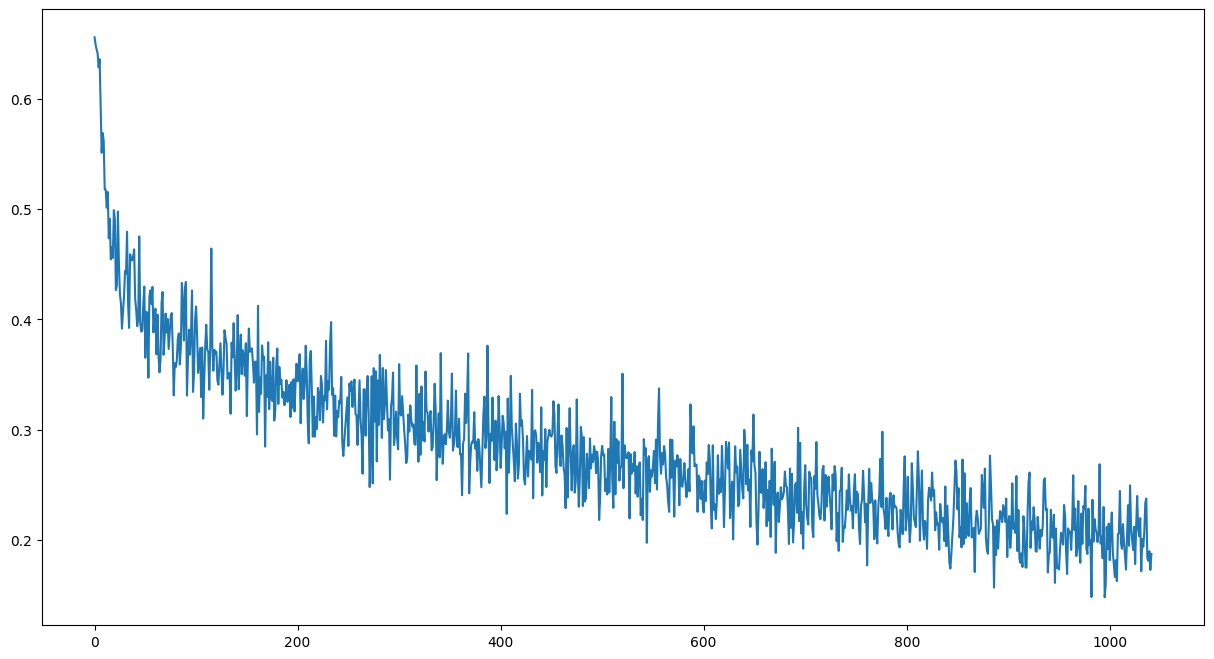

In [33]:
pd.Series(l_l[1:]).plot(figsize=(15, 8))